# README

This File is used to Train classification models to identify job industry from a given job title and job description from scrapped job posting data.

The goal of this model is to be able to identify the job industry from a given list of possible job industries. 
`technology, medical, marketing and sales, law, service industry, retail, education, customer service, engineering and architecture, skilled trades, hr, finance`

The initial version of this file was a binary classification model that predicted if the job was `tech` or `not tech`. This notebook expands on that work improving the technology binary classification model as well as adding a binary classification for the medical industry. Both of these models achieved very high-performance scores. The final model in this notebook is the multi-classification model for the 12 job industries and builds on the previous work done in the binary classification models. 

Distilled Bert LLM from hugging face is used as the base model that I fine-tuned with my own data. 

The data for this model was hand-labeled by me. I created an LLM model that used a clustering approach to attempt to label the data in an unsupervised approach which can be found in another notebook. The results of that model were not great but did provide a useful tool to get 'mostly' correct labels that allowed me to create filterable columns in Excel that made hand-labeling the data faster. In total 27 thousand examples were hand-labeled by me. 

I use the `sklearn` package for model metrics and evaluation. 

The models in this notebook were trained on my personal computer using Linux to enable GPU usage on my Nvidia 2080 super GPU.

# Imports

In [8]:
# Standard imports 
import os
import time
import torch
from datasets import Dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import swifter
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import unicodedata
import pickle
import json
import gc

# Transformers 
from transformers import DataCollatorWithPadding, DistilBertTokenizer, BertTokenizer,  \
                    DistilBertModel, TrainingArguments, Trainer, DistilBertTokenizerFast, DistilBertForSequenceClassification

# Metrics 
import evaluate
accuracy = evaluate.load("accuracy")
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

from accelerate import Accelerator
accelerator = Accelerator()

# NLP Imports
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    nltk.download('punkt')
stop_words = set(stopwords.words('english'))
tqdm.pandas()
from pynvml import *


In [2]:
# Helper Function to load the matching hugging face model and tokenizer.
model_dict = {
    'distilbert-base-uncased': (DistilBertModel, DistilBertTokenizer),
    # 'bert-base-uncased': (BertModel, BertTokenizer),
}
def load_model_and_tokenizer(model_name, use_gpu=True):
    """Loads the model and tokenizer from the given model name"""
    model_class, tokenizer_class = model_dict[model_name]
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name)
    
    if use_gpu and torch.cuda.is_available():
        model.to('cuda')
        print("Using GPU")
    else:
        print("Using CPU")
    
    return model, tokenizer

In [1]:
# Helper Function to monitor the GPU usage
def print_GPU():
    """Prints GPU Usage"""
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    total_memory = info.total // 1024**2  
    used_memory = info.used // 1024**2
    free_memory = info.free // 1024**2 
    print(f"Total GPU memory: {total_memory} MB")
    print(f"GPU memory occupied: {used_memory} MB")
    print(f"GPU memory free: {free_memory} MB")

In [4]:
print_GPU()

Total GPU memory: 8192 MB
GPU memory occupied: 1178 MB
GPU memory free: 7013 MB


# Helper Functions

In [3]:
def compute_metrics(eval_pred):
    """Compute accuracy from predictions and labels in eval_pred."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def build_confusion(y_true, y_pred, classes):
    """Build and display a confusion matrix with labels from y_true and y_pred."""
    cf_matrix = confusion_matrix(y_true, y_pred)
    make_confusion_matrix(cf_matrix, categories=classes, figsize=(8,6), cbar=False)

def eval_model(test_rows, classifier, id2label, token_max):
    """Evaluate the classifier on test data and return true and predicted labels."""
    tokenizer_args= {'truncation':True, 'max_length':token_max, 'padding':True}
    y_pred = []
    y_true = []
    for _, row in test_rows.iterrows():
        y_pred.append(classifier(preprocess_text(row['text']), **tokenizer_args)[0]['label'])
        y_true.append(id2label[row['label']])  
    return y_true, y_pred

def eval_example(example, tokenizer_args, classifier):
    """Evaluate a single example using the classifier and tokenizer arguments."""
    val = classifier(preprocess_text(example), **tokenizer_args)
    return val

def calc_accuracy(y_true,y_pred):
    """Calculate and print accuracy based on true and predicted labels."""
    accuracy = 0
    for x in range(len(y_true)):
        if y_pred[x]==y_true[x]:
            accuracy+=1
    print(f'Accuracy: {(accuracy/len(y_true))*100:.2f}%')
    
def make_confusion_matrix(cf,
                          categories='auto',
                          cbar=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    """Create and display a confusion matrix with optional color bar and title."""    
    group_labels = ['' for i in range(cf.size)]
    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    accuracy  = np.trace(cf) / float(np.sum(cf))
    stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    
    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)
    if title:
        plt.title(title)


def print_label_counts(split_datasets, label_column='label'):
    """Print label counts for each split dataset, grouped by label."""
    for split in ['train', 'test']:
        dataset = split_datasets[split] 
        labels = dataset[label_column]  
        
        if isinstance(labels, pd.Series):
            label_counts = labels.value_counts()
        else:
            label_counts = pd.Series(labels).value_counts()
        
        print(f"Label counts for {split} set:")
        print_string = ''
        for idx,[key,value] in enumerate(label_counts.items()):
            print_string += f"{key}: {value} "
            if idx != len(label_counts.keys())-1:
                print_string += "| "
            
        print(print_string)

def preprocess_text(text):
    """Clean and normalize text by removing unwanted characters and patterns."""
    if text is None:
        return text

    # Fix Contractions
    text = contractions.fix(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-standard UTF-8 characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Normalize accented characters to their ASCII equivalents
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')

    # Remove bullet points (at the start of a line or following whitespace)
    text = re.sub(r'(^[\s]*[\u2022\u2023\u25E6\u2043\u2219*•-]\s+)', '', text, flags=re.MULTILINE)

    # Replace URLs with "URL"
    text = re.sub(r'http\S+|www.\S+', 'URL', text)

    # Replace phone numbers with "PHONE_NUMBER"
    text = re.sub(r'\(?\b\d{3}[-.)\s]*\d{3}[-.\s]*\d{4}\b', 'PHONE_NUMBER', text)

    # Replace email addresses with "EMAIL"
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'EMAIL', text)

    # Replace more than three consecutive punctuation marks with a single instance
    text = re.sub(r'([^\w\s])\1{2,}', r'\1', text)

    # Remove parentheses, curly braces, and square brackets
    text = re.sub(r'[\(\)\{\}\[\]]', ' ', text)

    # Remove special characters 
    text = re.sub(r'[:;@\/\\*#!?]', ' ', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text
    
def remove_stop(sentence):
    """Remove stop words from the given sentence."""
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

def concat_columns(row, title_label, description_label):
    """Concatenate title and description columns with specific labels."""
    return f"[TITLE] {row[title_label]} [DESC] {row[description_label]}"

def make_new_df(df, label_col, minority_classes, majority_classes, num_majority, seed):
    """
    Creates a new randomly sampled Dataset with minority classes using all of their examples and 
    majority classes using num_majority int variable for the amount to sample
    """
    minority_df = df[df[label_col].isin(minority_classes)]
    
    majority_df = pd.concat([
        df[df[label_col] == label].sample(num_majority, random_state=seed) for label in majority_classes
    ])
    
    balanced_df = pd.concat([minority_df, majority_df]).reset_index(drop=True)
    
    balanced_df = balanced_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    return balanced_df

def format_rows_for_train(df, input_col, label_col):
    """
    Creates Training and test datasets. 
    """
    newdf = df.loc[df[label_col].notnull()].copy()    
    
    newdf.rename(columns={input_col: 'text'}, inplace=True)
    newdf.rename(columns={label_col: 'label'}, inplace=True)
    
    final_df = newdf[['text','label']].copy()
    training_rows_DS = Dataset.from_pandas(final_df)
    training_rows_DS = training_rows_DS.train_test_split(train_size=.8, seed=42) 

    train_rows = pd.DataFrame(list(zip(training_rows_DS['train']['text'], training_rows_DS['train']['label'])), columns =['text','label'])
    test_rows = pd.DataFrame(list(zip(training_rows_DS['test']['text'], training_rows_DS['test']['label'])), columns =['text','label'])
    
    return training_rows_DS, train_rows, test_rows

# Data Load 

## Data Load - binary classification models

In [13]:
raw_df = pd.read_csv('./job_type_data/title_w_labels_2.csv')
raw_df
# As seen in the print out the 4 labels_ columns are a result of my experimentation with a clustering approach.
# Each is a different run of the clustering model using different parameters

,company,title,description,title_processed,labels_10_2_12,labels_15_2_12,labels_10_2_10,labels_15_2_10,labels
0,snowflakecomputing,solutions architect,"We’re at the forefront of the data revolution,...",solutions architect,8,7,5,8,NaN
1,beyondfinance,"marketing analytics, sr. analyst","At Beyond Finance, we’ve made it our mission t...","marketing analytics, sr. analyst",10,0,6,0,3.0
2,goatgroup,fulfillment associate,About the team The Operations team manages our...,fulfillment associate,5,5,9,9,NaN
3,foresightmentalhealth,licensed mental health therapist (hybrid or re...,Welcome to Foresight Mental Health. We’re so g...,licensed mental health therapist hybrid or remote,11,2,3,5,2.0
4,nogginit,regional vp of sales - north america,Why join Noggin? Noggin has been in the crisis...,regional vp of sales - north america,10,0,6,0,3.0
...,...,...,...,...,...,...,...,...,...
29995,eositsolutions,unified collaborations engineer,WHO WE ARE: EOS IT Solutions is a family run G...,unified collaborations engineer,8,9,5,1,NaN
29996,schweigerdermatologygroup,licensed practical nurse - jamestown,Are you an experienced professional looking to...,licensed practical nurse - jamestown,8,2,8,1,2.0
29997,retool,"sales engineering manager, enterprise","ABOUT RETOOL: At Retool, we’re changing the wa...","sales engineering manager, enterprise",10,0,6,0,3.0
29998,pulse,anaesthetic nurse,Anaesthetic Theatre Practitioner Location: Mac...,anaesthetic nurse,9,11,1,1,2.0


In [20]:
labeled_df = raw_df[raw_df["labels"].notnull()]
labeled_df.reset_index(drop=True, inplace=True)

In [22]:
labeled_df.drop(['title_processed','labels_10_2_12','labels_15_2_12','labels_10_2_10','labels_15_2_10'], axis=1, inplace=True)

/tmp/ipykernel_1635997/1150074047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df.drop(['title_processed','labels_10_2_12','labels_15_2_12','labels_10_2_10','labels_15_2_10'], axis=1, inplace=True)


In [23]:
labeled_df

,company,title,description,labels
0,beyondfinance,"marketing analytics, sr. analyst","At Beyond Finance, we’ve made it our mission t...",3.0
1,foresightmentalhealth,licensed mental health therapist (hybrid or re...,Welcome to Foresight Mental Health. We’re so g...,2.0
2,nogginit,regional vp of sales - north america,Why join Noggin? Noggin has been in the crisis...,3.0
3,diginnother,"hiring immediately:dishwasher/prep cook, 57th ...",Dishwasher/Prep Cook $16 - $18 / hour dependin...,5.0
4,memorahealth,client success executive,Memora Health works with leading healthcare or...,8.0
...,...,...,...,...
11181,traegergrills,director of electrical engineering,Welcome To The Traegerhood: Our business is B...,9.0
11182,silverrail,qa engineer,**This is a 6 month fixed term contract positi...,1.0
11183,schweigerdermatologygroup,licensed practical nurse - jamestown,Are you an experienced professional looking to...,2.0
11184,retool,"sales engineering manager, enterprise","ABOUT RETOOL: At Retool, we’re changing the wa...",3.0


In [27]:
# Preprocessing is applied to both the title and description columns 
labeled_df['title_processed'] = labeled_df['title'].progress_apply(preprocess_text)
labeled_df['description_processed'] = labeled_df['description'].progress_apply(preprocess_text)

100%|██████████| 11186/11186 [00:00<00:00, 52191.95it/s]
/tmp/ipykernel_1635997/3470322254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['title_processed'] = labeled_df['title'].progress_apply(preprocess_text)
100%|██████████| 11186/11186 [00:07<00:00, 1455.66it/s]
/tmp/ipykernel_1635997/3470322254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['description_processed'] = labeled_df['description'].progress_apply(preprocess_text)


In [31]:
def remove_stop(sentence):
    """Removes stop words from the given string"""
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

In [36]:
# More preprocessing where Stop words are also removed was preformed on the already preprocessed strings 
# the idea was to see if removing stop words had any impact on model performance
labeled_df['description_processed_stop'] = labeled_df['description_processed'].progress_apply(remove_stop)
labeled_df['title_processed_stop'] = labeled_df['title_processed'].progress_apply(remove_stop)

100%|██████████| 11186/11186 [00:25<00:00, 445.83it/s]
/tmp/ipykernel_1635997/3915749175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['description_processed_stop'] = labeled_df['description_processed'].progress_apply(remove_stop)
100%|██████████| 11186/11186 [00:00<00:00, 19225.76it/s]
/tmp/ipykernel_1635997/3915749175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['title_processed_stop'] = labeled_df['title_processed'].progress_apply(remove_stop)


In [39]:
# Two sets of input rows are created where title and description are combined and prefixed with a special token that is later added to the tokenizer. 
# one set of input rows has stop words the other does not
labeled_df['input_row'] = labeled_df.progress_apply(lambda x: concat_columns(x, 'title_processed', 'description_processed'), axis=1)
labeled_df['input_row_stop'] = labeled_df.progress_apply(lambda x: concat_columns(x, 'title_processed_stop', 'description_processed_stop'), axis=1)

100%|██████████| 11186/11186 [00:00<00:00, 103403.29it/s]
/tmp/ipykernel_1635997/2088205664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['input_row'] = labeled_df.progress_apply(lambda x: concat_columns(x, 'title_processed', 'description_processed'), axis=1)
100%|██████████| 11186/11186 [00:00<00:00, 143067.72it/s]
/tmp/ipykernel_1635997/2088205664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['input_row_stop'] = labeled_df.progress_apply(lambda x: concat_columns(x, 'title

In [44]:
# Ensure the labels are ints
labeled_df['labels'] = labeled_df['labels'].astype(int)

/tmp/ipykernel_1635997/4227985788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['labels'] = labeled_df['labels'].astype(int)


In [45]:
# Check the counts of label values
labeled_df['labels'].value_counts()

labels
1     3494
2     2344
3     2010
13     892
8      842
7      518
4      430
12     272
5      133
9      130
10      75
6       46
Name: count, dtype: int64

In [46]:
# Check the counts of label values as percentages
labeled_df['labels'].value_counts(normalize=True) * 100

labels
1     31.235473
2     20.954765
3     17.968890
13     7.974254
8      7.527266
7      4.630788
4      3.844091
12     2.431611
5      1.188986
9      1.162167
10     0.670481
6      0.411228
Name: proportion, dtype: float64

In [84]:
labeled_df

,company,title,description,labels,title_processed,description_processed,description_processed_stop,title_processed_stop,input_row,input_row_stop,labels_tech,labels_med
0,beyondfinance,"marketing analytics, sr. analyst","At Beyond Finance, we’ve made it our mission t...",3,"marketing analytics, sr. analyst","at beyond finance, we have made it our mission...","beyond finance , made mission help everyday am...","marketing analytics , sr. analyst","[TITLE] marketing analytics, sr. analyst [DESC...","[TITLE] marketing analytics , sr. analyst [DES...",0,0
1,foresightmentalhealth,licensed mental health therapist (hybrid or re...,Welcome to Foresight Mental Health. We’re so g...,2,licensed mental health therapist hybrid or remote,welcome to foresight mental health. we are so ...,welcome foresight mental health . glad conside...,licensed mental health therapist hybrid remote,[TITLE] licensed mental health therapist hybri...,[TITLE] licensed mental health therapist hybri...,0,1
2,nogginit,regional vp of sales - north america,Why join Noggin? Noggin has been in the crisis...,3,regional vp of sales - north america,why join noggin noggin has been in the crisis ...,"join noggin noggin crisis response , security ...",regional vp sales - north america,[TITLE] regional vp of sales - north america [...,[TITLE] regional vp sales - north america [DES...,0,0
3,diginnother,"hiring immediately:dishwasher/prep cook, 57th ...",Dishwasher/Prep Cook $16 - $18 / hour dependin...,5,"hiring immediately dishwasher prep cook, 57th ...",dishwasher prep cook $16 - $18 hour depending ...,dishwasher prep cook $ 16 - $ 18 hour dependin...,"hiring immediately dishwasher prep cook , 57th...",[TITLE] hiring immediately dishwasher prep coo...,[TITLE] hiring immediately dishwasher prep coo...,0,0
4,memorahealth,client success executive,Memora Health works with leading healthcare or...,8,client success executive,memora health works with leading healthcare or...,memora health works leading healthcare organiz...,client success executive,[TITLE] client success executive [DESC] memora...,[TITLE] client success executive [DESC] memora...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11181,traegergrills,director of electrical engineering,Welcome To The Traegerhood: Our business is B...,9,director of electrical engineering,welcome to the traegerhood our business is bbq...,"welcome traegerhood business bbq , business ta...",director electrical engineering,[TITLE] director of electrical engineering [DE...,[TITLE] director electrical engineering [DESC]...,0,0
11182,silverrail,qa engineer,**This is a 6 month fixed term contract positi...,1,qa engineer,this is a 6 month fixed term contract position...,6 month fixed term contract position possibili...,qa engineer,[TITLE] qa engineer [DESC] this is a 6 month f...,[TITLE] qa engineer [DESC] 6 month fixed term ...,1,0
11183,schweigerdermatologygroup,licensed practical nurse - jamestown,Are you an experienced professional looking to...,2,licensed practical nurse - jamestown,are you an experienced professional looking to...,experienced professional looking join company ...,licensed practical nurse - jamestown,[TITLE] licensed practical nurse - jamestown [...,[TITLE] licensed practical nurse - jamestown [...,0,1
11184,retool,"sales engineering manager, enterprise","ABOUT RETOOL: At Retool, we’re changing the wa...",3,"sales engineering manager, enterprise","about retool at retool, we are changing the wa...","retool retool , changing way software built . ...","sales engineering manager , enterprise","[TITLE] sales engineering manager, enterprise ...","[TITLE] sales engineering manager , enterprise...",0,0


##### The Below cells are used to create the technology and medical data sets for the binary classification models. Percentages of labels in each set are printed after build.

In [48]:
labeled_df['labels_tech'] = labeled_df['labels'].apply(lambda x: 0 if x != 1 else 1)

/tmp/ipykernel_1635997/1849720009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['labels_tech'] = labeled_df['labels'].apply(lambda x: 0 if x != 1 else 1)


In [49]:
labeled_df['labels_tech'].value_counts(normalize=True) * 100

labels_tech
0    68.764527
1    31.235473
Name: proportion, dtype: float64

In [50]:
labeled_df['labels_med'] = labeled_df['labels'].apply(lambda x: 0 if x != 2 else 1)
labeled_df['labels_med'].value_counts(normalize=True) * 100

/tmp/ipykernel_1635997/3543593824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['labels_med'] = labeled_df['labels'].apply(lambda x: 0 if x != 2 else 1)


labels_med
0    79.045235
1    20.954765
Name: proportion, dtype: float64

## Data Load - all label categories 

In [118]:
all_df_93 = pd.read_csv('./job_type_data/jobs_93k.csv')

/tmp/ipykernel_1635997/2680190632.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df_93 = pd.read_csv('job_type_data/jobs_93k.csv')


In [129]:
# Data Set contains 93 thousand rows of which 27 thousand were hand labeled. This Cell was re ran after cells below it were run to just show the labeled rows.
all_df_93

,company,title,description,title_processed,labels
0,capitalone::wd1::Capital_One,"Sr. Lead Software Engineer, Full Stack - Capit...","Recruiting: US Remote, United States of Americ...","sr. lead software engineer, full stack - capit...",1
1,theoriamedical,Physician,"Position Type:Part-time, exemptCompensation: U...",physician,2
2,hntb::wd5::HNTB_Careers,Structural Engineer II,"What Were Looking ForAt HNTB, you can create a...",structural engineer ii,9
3,anaplan,Technical Content Writer,"At Anaplan, we are a team of innovators who ar...",technical content writer,3
4,bridgestone::wd5::external,Store Manager,Company OverviewBridgestone Retail Operations ...,store manager,6
...,...,...,...,...,...
27187,ghr::wd1::Lateral-US,Quantitative Finance Analyst,Job Description:Overview of Global Risk Analyt...,quantitative finance analyst,13
27188,maxine::wd3::Maxis-Career,Senior Tax Specialist,Are you ready to get ahead in your career?We w...,senior tax specialist,13
27189,bannerhealth::wd5::Careers,Registered Nurse RN Emergency Department,"Primary City/State:Sun City West, ArizonaDepar...",registered nurse right now emergency department,2
27190,ngc::wd1::Northrop_Grumman_External_Site,Software Engineering Manager 1,RELOCATION ASSISTANCE: Relocation assistance ...,software engineering manager 1,1


In [121]:
all_df_93.drop(['Unnamed: 0','Unnamed: 7','Unnamed: 8','.'], axis=1, inplace=True)

In [123]:
# Nulls Dropped
all_df_93 = all_df_93[all_df_93["labels"].notnull()]
all_df_93.reset_index(drop=True, inplace=True)

In [128]:
all_df_93["labels"] = all_df_93["labels"].astype(int)
all_df_93["title"] = all_df_93["title"].astype(str)
all_df_93["company"] = all_df_93["company"].astype(str)
all_df_93["description"] = all_df_93["description"].astype(str)
all_df_93["title_processed"] = all_df_93["title_processed"].astype(str)

/tmp/ipykernel_1635997/3195078337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93["labels"] = all_df_93["labels"].astype(int)
/tmp/ipykernel_1635997/3195078337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93["title"] = all_df_93["title"].astype(str)
/tmp/ipykernel_1635997/3195078337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [130]:
# Value label counts printed out
all_df_93['labels'].value_counts()

labels
2     6534
6     4908
1     4900
13    2593
3     2200
8     2038
5     1046
10     952
9      849
12     665
4      493
7       14
Name: count, dtype: int64

In [131]:
all_df_93['labels'].value_counts(normalize=True) * 100

labels
2     24.029126
6     18.049426
1     18.020006
13     9.535893
3      8.090615
8      7.494851
5      3.846720
10     3.501030
9      3.122242
12     2.445572
4      1.813033
7      0.051486
Name: proportion, dtype: float64

In [132]:
# This was not done on the title as the title was pre-processed when the 93k data set was originally created in another notebook using the same pre-processing code in the helper function section above. 
all_df_93['description_processed'] = all_df_93['description'].progress_apply(preprocess_text)

Pandas Apply:   0%|          | 0/27192 [00:00<?, ?it/s]

/tmp/ipykernel_1635997/2836500872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93['description_processed'] = all_df_93['description'].progress_apply(preprocess_text)


In [133]:
# The same approach as taken in the binary classification data load is taken here where stop words are removed
all_df_93['description_processed_stop'] = all_df_93['description_processed'].progress_apply(remove_stop)
all_df_93['title_processed_stop'] = all_df_93['title_processed'].progress_apply(remove_stop)

Pandas Apply:   0%|          | 0/27192 [00:00<?, ?it/s]

/tmp/ipykernel_1635997/1192338874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93['description_processed_stop'] = all_df_93['description_processed'].progress_apply(remove_stop)


Pandas Apply:   0%|          | 0/27192 [00:00<?, ?it/s]

/tmp/ipykernel_1635997/1192338874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93['title_processed_stop'] = all_df_93['title_processed'].progress_apply(remove_stop)


In [135]:
# Again 2 input rows are created here one with stop words and one without.
all_df_93['input_row'] = all_df_93.progress_apply(lambda x: concat_columns(x, 'title_processed', 'description_processed'), axis=1)
all_df_93['input_row_stop'] = all_df_93.progress_apply(lambda x: concat_columns(x, 'title_processed_stop', 'description_processed_stop'), axis=1)

Pandas Apply:   0%|          | 0/27192 [00:00<?, ?it/s]

/tmp/ipykernel_1635997/1556213652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93['input_row'] = all_df_93.progress_apply(lambda x: concat_columns(x, 'title_processed', 'description_processed'), axis=1)


Pandas Apply:   0%|          | 0/27192 [00:00<?, ?it/s]

/tmp/ipykernel_1635997/1556213652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_93['input_row_stop'] = all_df_93.progress_apply(lambda x: concat_columns(x, 'title_processed_stop', 'description_processed_stop'), axis=1)


In [136]:
all_df_93

,company,title,description,title_processed,labels,description_processed,description_processed_stop,title_processed_stop,input_row,input_row_stop
0,capitalone::wd1::Capital_One,"Sr. Lead Software Engineer, Full Stack - Capit...","Recruiting: US Remote, United States of Americ...","sr. lead software engineer, full stack - capit...",1,"recruiting us remote, united states of america...","recruiting us remote , united states americasr...","sr. lead software engineer , full stack - capi...","[TITLE] sr. lead software engineer, full stack...","[TITLE] sr. lead software engineer , full stac..."
1,theoriamedical,Physician,"Position Type:Part-time, exemptCompensation: U...",physician,2,"position type part-time, exemptcompensation up...","position type part-time , exemptcompensation $...",physician,[TITLE] physician [DESC] position type part-ti...,[TITLE] physician [DESC] position type part-ti...
2,hntb::wd5::HNTB_Careers,Structural Engineer II,"What Were Looking ForAt HNTB, you can create a...",structural engineer ii,9,"what were looking forat hntb, you can create a...","looking forat hntb , create career meaningful ...",structural engineer ii,[TITLE] structural engineer ii [DESC] what wer...,[TITLE] structural engineer ii [DESC] looking ...
3,anaplan,Technical Content Writer,"At Anaplan, we are a team of innovators who ar...",technical content writer,3,"at anaplan, we are a team of innovators who ar...","anaplan , team innovators focused optimizing b...",technical content writer,[TITLE] technical content writer [DESC] at ana...,[TITLE] technical content writer [DESC] anapla...
4,bridgestone::wd5::external,Store Manager,Company OverviewBridgestone Retail Operations ...,store manager,6,company overviewbridgestone retail operations ...,company overviewbridgestone retail operations ...,store manager,[TITLE] store manager [DESC] company overviewb...,[TITLE] store manager [DESC] company overviewb...
...,...,...,...,...,...,...,...,...,...,...
27187,ghr::wd1::Lateral-US,Quantitative Finance Analyst,Job Description:Overview of Global Risk Analyt...,quantitative finance analyst,13,job description overview of global risk analyt...,job description overview global risk analytics...,quantitative finance analyst,[TITLE] quantitative finance analyst [DESC] jo...,[TITLE] quantitative finance analyst [DESC] jo...
27188,maxine::wd3::Maxis-Career,Senior Tax Specialist,Are you ready to get ahead in your career?We w...,senior tax specialist,13,are you ready to get ahead in your career we w...,ready get ahead career want empower turn ambit...,senior tax specialist,[TITLE] senior tax specialist [DESC] are you r...,[TITLE] senior tax specialist [DESC] ready get...
27189,bannerhealth::wd5::Careers,Registered Nurse RN Emergency Department,"Primary City/State:Sun City West, ArizonaDepar...",registered nurse right now emergency department,2,"primary city state sun city west, arizonadepar...","primary city state sun city west , arizonadepa...",registered nurse right emergency department,[TITLE] registered nurse right now emergency d...,[TITLE] registered nurse right emergency depar...
27190,ngc::wd1::Northrop_Grumman_External_Site,Software Engineering Manager 1,RELOCATION ASSISTANCE: Relocation assistance ...,software engineering manager 1,1,relocation assistance relocation assistance ma...,relocation assistance relocation assistance ma...,software engineering manager 1,[TITLE] software engineering manager 1 [DESC] ...,[TITLE] software engineering manager 1 [DESC] ...


In [138]:
# Tech and med labels are dropped.
temp_df_for_concat = labeled_df.drop(['labels_tech', 'labels_med'], axis=1)

In [139]:
temp_df_for_concat

,company,title,description,labels,title_processed,description_processed,description_processed_stop,title_processed_stop,input_row,input_row_stop
0,beyondfinance,"marketing analytics, sr. analyst","At Beyond Finance, we’ve made it our mission t...",3,"marketing analytics, sr. analyst","at beyond finance, we have made it our mission...","beyond finance , made mission help everyday am...","marketing analytics , sr. analyst","[TITLE] marketing analytics, sr. analyst [DESC...","[TITLE] marketing analytics , sr. analyst [DES..."
1,foresightmentalhealth,licensed mental health therapist (hybrid or re...,Welcome to Foresight Mental Health. We’re so g...,2,licensed mental health therapist hybrid or remote,welcome to foresight mental health. we are so ...,welcome foresight mental health . glad conside...,licensed mental health therapist hybrid remote,[TITLE] licensed mental health therapist hybri...,[TITLE] licensed mental health therapist hybri...
2,nogginit,regional vp of sales - north america,Why join Noggin? Noggin has been in the crisis...,3,regional vp of sales - north america,why join noggin noggin has been in the crisis ...,"join noggin noggin crisis response , security ...",regional vp sales - north america,[TITLE] regional vp of sales - north america [...,[TITLE] regional vp sales - north america [DES...
3,diginnother,"hiring immediately:dishwasher/prep cook, 57th ...",Dishwasher/Prep Cook $16 - $18 / hour dependin...,5,"hiring immediately dishwasher prep cook, 57th ...",dishwasher prep cook $16 - $18 hour depending ...,dishwasher prep cook $ 16 - $ 18 hour dependin...,"hiring immediately dishwasher prep cook , 57th...",[TITLE] hiring immediately dishwasher prep coo...,[TITLE] hiring immediately dishwasher prep coo...
4,memorahealth,client success executive,Memora Health works with leading healthcare or...,8,client success executive,memora health works with leading healthcare or...,memora health works leading healthcare organiz...,client success executive,[TITLE] client success executive [DESC] memora...,[TITLE] client success executive [DESC] memora...
...,...,...,...,...,...,...,...,...,...,...
11181,traegergrills,director of electrical engineering,Welcome To The Traegerhood: Our business is B...,9,director of electrical engineering,welcome to the traegerhood our business is bbq...,"welcome traegerhood business bbq , business ta...",director electrical engineering,[TITLE] director of electrical engineering [DE...,[TITLE] director electrical engineering [DESC]...
11182,silverrail,qa engineer,**This is a 6 month fixed term contract positi...,1,qa engineer,this is a 6 month fixed term contract position...,6 month fixed term contract position possibili...,qa engineer,[TITLE] qa engineer [DESC] this is a 6 month f...,[TITLE] qa engineer [DESC] 6 month fixed term ...
11183,schweigerdermatologygroup,licensed practical nurse - jamestown,Are you an experienced professional looking to...,2,licensed practical nurse - jamestown,are you an experienced professional looking to...,experienced professional looking join company ...,licensed practical nurse - jamestown,[TITLE] licensed practical nurse - jamestown [...,[TITLE] licensed practical nurse - jamestown [...
11184,retool,"sales engineering manager, enterprise","ABOUT RETOOL: At Retool, we’re changing the wa...",3,"sales engineering manager, enterprise","about retool at retool, we are changing the wa...","retool retool , changing way software built . ...","sales engineering manager , enterprise","[TITLE] sales engineering manager, enterprise ...","[TITLE] sales engineering manager , enterprise..."


In [140]:
all_cat_df = pd.concat([all_df_93, temp_df_for_concat]).reset_index(drop=True)

In [144]:
all_cat_df['labels'].value_counts()

labels
2     8878
1     8394
6     4954
3     4210
13    3485
8     2880
5     1179
10    1027
9      979
12     937
4      923
7      532
Name: count, dtype: int64

In [145]:
# When I hand-labeled data I messed up the ids on the labels. This dictionary was used to fix the labels to start at a 0 index as well as fix the gaps in the label scheme. 
# id2label = {1:  "technology", 2: "medical", 3:"marketing and sales", 4:"law", 5: "service industry", 6:"retail", 7:"education", 8:"customer service", 9:"engineering and architecture", 10: "skilled trades", 11: "hr", 12: "finance"}
id_mapping = {1: 0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9, 12:10, 13:11 }

In [148]:
all_cat_df['labels_fixed'] = all_cat_df['labels'].progress_apply(lambda x: id_mapping[x])

Pandas Apply:   0%|          | 0/38378 [00:00<?, ?it/s]

In [149]:
all_cat_df['labels_fixed'].value_counts()

labels_fixed
1     8878
0     8394
5     4954
2     4210
11    3485
7     2880
4     1179
9     1027
8      979
10     937
3      923
6      532
Name: count, dtype: int64

In [159]:
# old labels dropped and the csv was saved to fix my mistake.
df_to_save = all_cat_df.drop(['labels'], axis=1)

In [ ]:
df_to_save.to_csv('./job_type_data/hand_labeled_38k.csv', header=True, index=False)

In [8]:
all_cat_df=pd.read_csv('./job_type_data/hand_labeled_38k.csv',  index_col=0)

In [9]:
all_cat_df

,title,description,title_processed,description_processed,description_processed_stop,title_processed_stop,input_row,input_row_stop,labels_fixed
company,,,,,,,,,
capitalone::wd1::Capital_One,"Sr. Lead Software Engineer, Full Stack - Capit...","Recruiting: US Remote, United States of Americ...","sr. lead software engineer, full stack - capit...","recruiting us remote, united states of america...","recruiting us remote , united states americasr...","sr. lead software engineer , full stack - capi...","[TITLE] sr. lead software engineer, full stack...","[TITLE] sr. lead software engineer , full stac...",0
theoriamedical,Physician,"Position Type:Part-time, exemptCompensation: U...",physician,"position type part-time, exemptcompensation up...","position type part-time , exemptcompensation $...",physician,[TITLE] physician [DESC] position type part-ti...,[TITLE] physician [DESC] position type part-ti...,1
hntb::wd5::HNTB_Careers,Structural Engineer II,"What Were Looking ForAt HNTB, you can create a...",structural engineer ii,"what were looking forat hntb, you can create a...","looking forat hntb , create career meaningful ...",structural engineer ii,[TITLE] structural engineer ii [DESC] what wer...,[TITLE] structural engineer ii [DESC] looking ...,8
anaplan,Technical Content Writer,"At Anaplan, we are a team of innovators who ar...",technical content writer,"at anaplan, we are a team of innovators who ar...","anaplan , team innovators focused optimizing b...",technical content writer,[TITLE] technical content writer [DESC] at ana...,[TITLE] technical content writer [DESC] anapla...,2
bridgestone::wd5::external,Store Manager,Company OverviewBridgestone Retail Operations ...,store manager,company overviewbridgestone retail operations ...,company overviewbridgestone retail operations ...,store manager,[TITLE] store manager [DESC] company overviewb...,[TITLE] store manager [DESC] company overviewb...,5
...,...,...,...,...,...,...,...,...,...
traegergrills,director of electrical engineering,Welcome To The Traegerhood: Our business is B...,director of electrical engineering,welcome to the traegerhood our business is bbq...,"welcome traegerhood business bbq , business ta...",director electrical engineering,[TITLE] director of electrical engineering [DE...,[TITLE] director electrical engineering [DESC]...,8
silverrail,qa engineer,**This is a 6 month fixed term contract positi...,qa engineer,this is a 6 month fixed term contract position...,6 month fixed term contract position possibili...,qa engineer,[TITLE] qa engineer [DESC] this is a 6 month f...,[TITLE] qa engineer [DESC] 6 month fixed term ...,0
schweigerdermatologygroup,licensed practical nurse - jamestown,Are you an experienced professional looking to...,licensed practical nurse - jamestown,are you an experienced professional looking to...,experienced professional looking join company ...,licensed practical nurse - jamestown,[TITLE] licensed practical nurse - jamestown [...,[TITLE] licensed practical nurse - jamestown [...,1


In [11]:
# Create 2 sampled Datasets. 
label_col= 'labels_fixed'
minority_classes = [4, 9, 8, 10, 3, 6]
majority_classes = [1, 0, 5, 2, 11, 7]
num_majority = 2000
seed = 42

balanced_df_1 = make_new_df(all_cat_df, label_col, minority_classes, majority_classes, num_majority, seed)
print(balanced_df_1[label_col].value_counts())

labels_fixed
1     2000
7     2000
2     2000
5     2000
0     2000
11    2000
4     1179
9     1027
8      979
10     937
3      923
6      532
Name: count, dtype: int64


In [12]:
seed = 62

balanced_df_2 = make_new_df(all_cat_df, label_col, minority_classes, majority_classes, num_majority, seed)
print(balanced_df_2[label_col].value_counts())

labels_fixed
0     2000
7     2000
11    2000
2     2000
5     2000
1     2000
4     1179
9     1027
8      979
10     937
3      923
6      532
Name: count, dtype: int64


# Model function

In [13]:
def run_model_v9(train_rows, test_rows, tokenizer, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  should_return=False):
    
    def preprocess(examples):  
        return tokenizer(examples['text'], **tokenizer_config)

    train_rows_DS = Dataset.from_pandas(train_rows)
    test_rows_DS = Dataset.from_pandas(test_rows)
        
    train_rows_DS = train_rows_DS.map(preprocess, batched=True)
    test_rows_DS = test_rows_DS.map(preprocess, batched=True)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    
    base_model = accelerator.prepare(base_model)
    
    training_args = TrainingArguments(
        output_dir=out_put_dir,
        overwrite_output_dir=True, 
        num_train_epochs=epochs, 
        per_device_train_batch_size=train_batch, 
        per_device_eval_batch_size=test_batch,  
        load_best_model_at_end=True,
        logging_steps=5,
        log_level='info',
        evaluation_strategy='epoch',
        save_strategy='epoch'
    )

    trainer = Trainer(
        model=base_model,
        args=training_args,
        train_dataset=train_rows_DS,
        eval_dataset=test_rows_DS,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    eval_results_before = trainer.evaluate()
    
    train_results = trainer.train()
    
    eval_results_after = trainer.evaluate()
    
    trainer.save_model()
    
    classifier = pipeline('text-classification', model=out_put_dir, tokenizer=tokenizer, device=0)
    
    y_true, y_pred = eval_model(test_rows, classifier, id2label, tokenizer_config['max_length'])
    
    
    print(f'Eval Model before train')
    print(f"Accuracy: {(eval_results_before['eval_accuracy'])*100:.2f}%, Loss: {eval_results_before['eval_loss']:.2f}, Time: {eval_results_before['eval_runtime']}")
    print(f'Eval Model After train')
    print(f"Accuracy: {(eval_results_after['eval_accuracy'])*100:.2f}%, Loss: {eval_results_after['eval_loss']:.2f}, Time: {eval_results_after['eval_runtime']}")
        
    build_confusion(y_true, y_pred, label2id.keys())
    

    del trainer, classifier
    gc.collect()
    torch.cuda.empty_cache()
    
    if should_return:
        return ((eval_results_after['eval_accuracy'])*100)

# Model Runs 

## Base Model Load tech
This Model is a binary classification between tech and non tech jobs with stop words included. 

It achieved a 99.8% accuracy

In [76]:
max_length=512
out_put_dir = f"./jobLevel_multi_bert_tech"
id2label = {0: "other", 1:  "technology"}
label2id = {"other":0, "technology": 1}
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': True}

train_batch = 4
test_batch = 4
epochs = 5

tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).cuda()

special_tokens_dict = {'additional_special_tokens': ['[TITLE]', '[DESC]']}
tokenizer_funct.add_special_tokens(special_tokens_dict)
base_model.resize_token_embeddings(len(tokenizer_funct))
print_GPU()

loading file vocab.txt from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading configuration file config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout":

Total GPU memory: 8192 MB
GPU memory occupied: 4255 MB
GPU memory free: 3936 MB


Label counts for train set:
0: 6140 | 1: 2808 
Label counts for test set:
0: 1552 | 1: 686 


Map:   0%|          | 0/8948 [00:00<?, ? examples/s]

Map:   0%|          | 0/2238 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4


The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,948
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 11,185
  Number of trainable parameters = 66,956,546


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.000100,0.035337,0.001000,0.995532
2,0.000100,0.037848,0.001000,0.995979
3,0.277400,0.033841,0.001000,0.995979
4,0.000000,0.023273,0.001000,0.996872
5,0.000000,0.014507,0.001000,0.998213


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_tech/checkpoint-2237
Configuration saved in ./jobLevel_multi_bert_tech/checkpoint-2237/config.json
Model weights saved in ./jobLevel_multi_bert_tech/checkpoint-2237/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_tech/checkpoint-4474
Configuration sa

Saving model checkpoint to ./jobLevel_multi_bert_tech
Configuration saved in ./jobLevel_multi_bert_tech/config.json
Model weights saved in ./jobLevel_multi_bert_tech/model.safetensors
loading configuration file ./jobLevel_multi_bert_tech/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_multi_bert_tech",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "other",
    "1": "technology"
  },
  "initializer_range": 0.02,
  "label2id": {
    "other": 0,
    "technology": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.43.3",
  "vocab

Eval Model before train
Accuracy: 69.35%, Loss: 0.67, Time: 16.3633
Eval Model After train
Accuracy: 99.82%, Loss: 0.01, Time: 16.2407


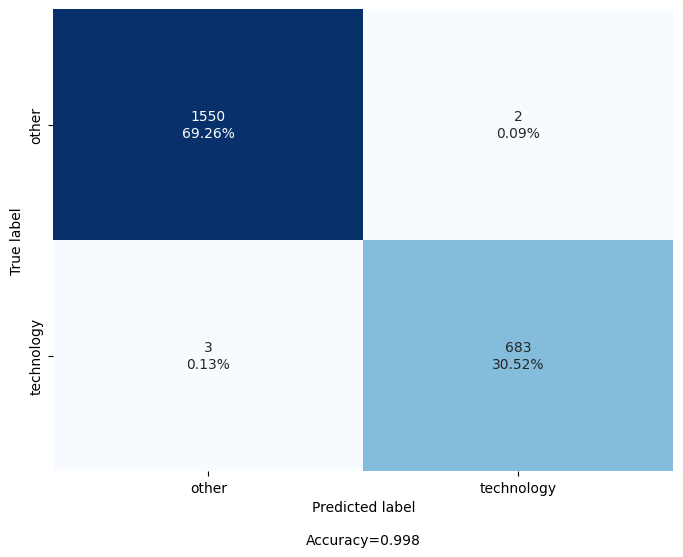

In [77]:
training_rows_DS, train_rows, test_rows = format_rows_for_train(labeled_df, 'input_row', 'labels_tech')
print_label_counts(training_rows_DS)
accuracy_metric = run_model_v9(train_rows, test_rows, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  True)

del base_model
gc.collect()
torch.cuda.empty_cache()

## Base Model Load tech no stop
This Model is a binary classification between tech and non tech jobs with stop words Removed.

It achieved a 99.6% accuracy

In [78]:
max_length=512
out_put_dir = f"./jobLevel_multi_bert_tech_no_stop"
id2label = {0: "other", 1:  "technology"}
label2id = {"other":0, "technology": 1}
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': True}

train_batch = 4
test_batch = 4
epochs = 5

tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).cuda()

special_tokens_dict = {'additional_special_tokens': ['[TITLE]', '[DESC]']}
tokenizer_funct.add_special_tokens(special_tokens_dict)
base_model.resize_token_embeddings(len(tokenizer_funct))

loading file vocab.txt from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading configuration file config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout":

Embedding(30524, 768, padding_idx=0)

Label counts for train set:
0: 6140 | 1: 2808 
Label counts for test set:
0: 1552 | 1: 686 


Map:   0%|          | 0/8948 [00:00<?, ? examples/s]

Map:   0%|          | 0/2238 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4


The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,948
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 11,185
  Number of trainable parameters = 66,956,546


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.403700,0.039203,0.001000,0.994638
2,0.000100,0.021070,0.001000,0.996872
3,0.001200,0.017469,0.001000,0.997766
4,0.000100,0.011433,0.001000,0.998213
5,0.000000,0.013066,0.001000,0.998660


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_tech_no_stop/checkpoint-2237
Configuration saved in ./jobLevel_multi_bert_tech_no_stop/checkpoint-2237/config.json
Model weights saved in ./jobLevel_multi_bert_tech_no_stop/checkpoint-2237/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_tech_no_stop/

Saving model checkpoint to ./jobLevel_multi_bert_tech_no_stop
Configuration saved in ./jobLevel_multi_bert_tech_no_stop/config.json
Model weights saved in ./jobLevel_multi_bert_tech_no_stop/model.safetensors
loading configuration file ./jobLevel_multi_bert_tech_no_stop/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_multi_bert_tech_no_stop",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "other",
    "1": "technology"
  },
  "initializer_range": 0.02,
  "label2id": {
    "other": 0,
    "technology": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "t

Eval Model before train
Accuracy: 69.26%, Loss: 0.68, Time: 16.3595
Eval Model After train
Accuracy: 99.82%, Loss: 0.01, Time: 16.3075


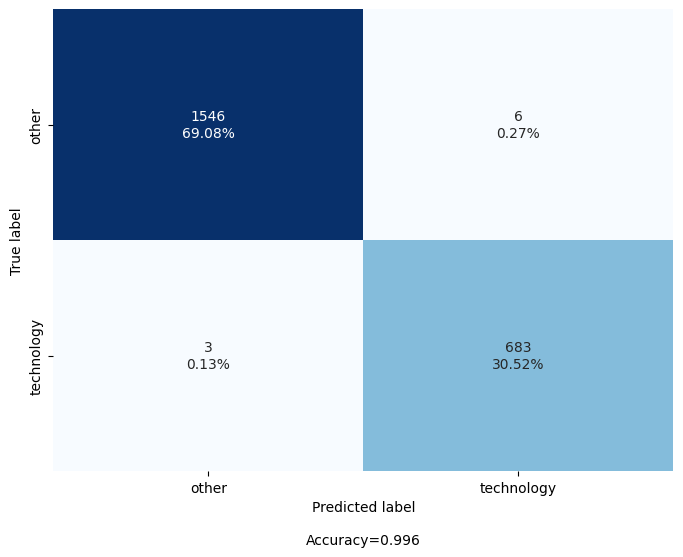

In [79]:
training_rows_DS, train_rows, test_rows = format_rows_for_train(labeled_df, 'input_row_stop', 'labels_tech')
print_label_counts(training_rows_DS)

accuracy_metric = run_model_v9(train_rows, test_rows, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  True)

del base_model
gc.collect()
torch.cuda.empty_cache()

## Base Model Load med
This Model is a binary classification between medical and non medical jobs with stop words included.

It achieved a 99.8% accuracy

In [80]:
max_length=512
out_put_dir = f"./jobLevel_multi_bert_med"
id2label = {0: "other", 1:  "med"}
label2id = {"other":0, "med": 1}
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': True}

train_batch = 4
test_batch = 4
epochs = 5

tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).cuda()

special_tokens_dict = {'additional_special_tokens': ['[TITLE]', '[DESC]']}
tokenizer_funct.add_special_tokens(special_tokens_dict)
base_model.resize_token_embeddings(len(tokenizer_funct))

loading file vocab.txt from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading configuration file config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout":

Embedding(30524, 768, padding_idx=0)

Label counts for train set:
0: 7078 | 1: 1870 
Label counts for test set:
0: 1764 | 1: 474 


Map:   0%|          | 0/8948 [00:00<?, ? examples/s]

Map:   0%|          | 0/2238 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4


The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,948
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 11,185
  Number of trainable parameters = 66,956,546


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.000200,0.024547,0.001000,0.995085
2,0.000000,0.020991,0.001000,0.997766
3,0.000000,0.030034,0.001000,0.996425
4,0.360300,0.029028,0.001000,0.996425
5,0.000000,0.036449,0.001000,0.995979


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_med/checkpoint-2237
Configuration saved in ./jobLevel_multi_bert_med/checkpoint-2237/config.json
Model weights saved in ./jobLevel_multi_bert_med/checkpoint-2237/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_med/checkpoint-4474
Configuration saved 

Saving model checkpoint to ./jobLevel_multi_bert_med
Configuration saved in ./jobLevel_multi_bert_med/config.json
Model weights saved in ./jobLevel_multi_bert_med/model.safetensors
loading configuration file ./jobLevel_multi_bert_med/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_multi_bert_med",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "other",
    "1": "med"
  },
  "initializer_range": 0.02,
  "label2id": {
    "med": 1,
    "other": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.43.3",
  "vocab_size": 30524
}

lo

Eval Model before train
Accuracy: 78.64%, Loss: 0.67, Time: 16.3624
Eval Model After train
Accuracy: 99.78%, Loss: 0.02, Time: 16.3214


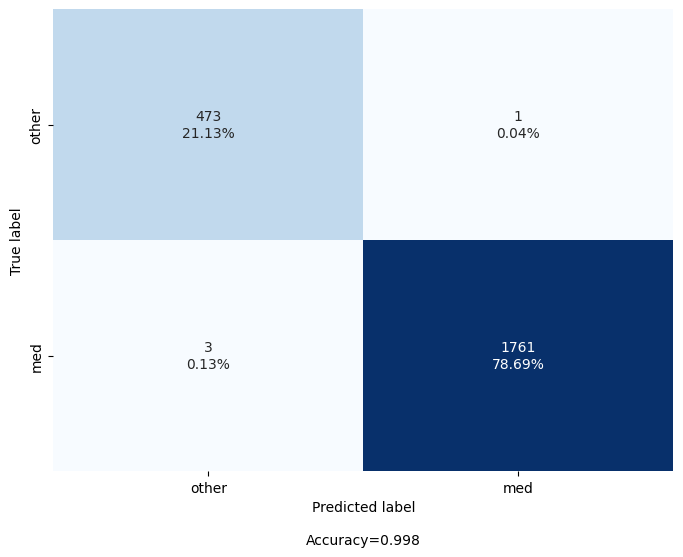

In [81]:
training_rows_DS, train_rows, test_rows = format_rows_for_train(labeled_df, 'input_row_stop', 'labels_med')
print_label_counts(training_rows_DS)

accuracy_metric = run_model_v9(train_rows, test_rows, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  True)

del base_model
gc.collect()
torch.cuda.empty_cache()

## Base Model Load med no stop
This Model is a binary classification between medical and non medical jobs with stop words removed.

It achieved a 99.8% accuracy

In [82]:
max_length=512
out_put_dir = f"./jobLevel_multi_bert_med_no_stop"
id2label = {0: "other", 1:  "med"}
label2id = {"other":0, "med": 1}
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': True}

train_batch = 4
test_batch = 4
epochs = 5

tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).cuda()

special_tokens_dict = {'additional_special_tokens': ['[TITLE]', '[DESC]']}
tokenizer_funct.add_special_tokens(special_tokens_dict)
base_model.resize_token_embeddings(len(tokenizer_funct))

loading file vocab.txt from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading configuration file config.json from cache at /home/connor/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout":

Embedding(30524, 768, padding_idx=0)

Label counts for train set:
0: 7078 | 1: 1870 
Label counts for test set:
0: 1764 | 1: 474 


Map:   0%|          | 0/8948 [00:00<?, ? examples/s]

Map:   0%|          | 0/2238 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4


The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,948
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 11,185
  Number of trainable parameters = 66,956,546


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.000200,0.024547,0.001000,0.995085
2,0.000000,0.020991,0.001000,0.997766
3,0.000000,0.030034,0.001000,0.996425
4,0.360300,0.029028,0.001000,0.996425
5,0.000000,0.036449,0.001000,0.995979


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_med_no_stop/checkpoint-2237
Configuration saved in ./jobLevel_multi_bert_med_no_stop/checkpoint-2237/config.json
Model weights saved in ./jobLevel_multi_bert_med_no_stop/checkpoint-2237/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2238
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_med_no_stop/chec

Saving model checkpoint to ./jobLevel_multi_bert_med_no_stop
Configuration saved in ./jobLevel_multi_bert_med_no_stop/config.json
Model weights saved in ./jobLevel_multi_bert_med_no_stop/model.safetensors
loading configuration file ./jobLevel_multi_bert_med_no_stop/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_multi_bert_med_no_stop",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "other",
    "1": "med"
  },
  "initializer_range": 0.02,
  "label2id": {
    "med": 1,
    "other": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version

Eval Model before train
Accuracy: 78.64%, Loss: 0.67, Time: 16.3635
Eval Model After train
Accuracy: 99.78%, Loss: 0.02, Time: 16.2819


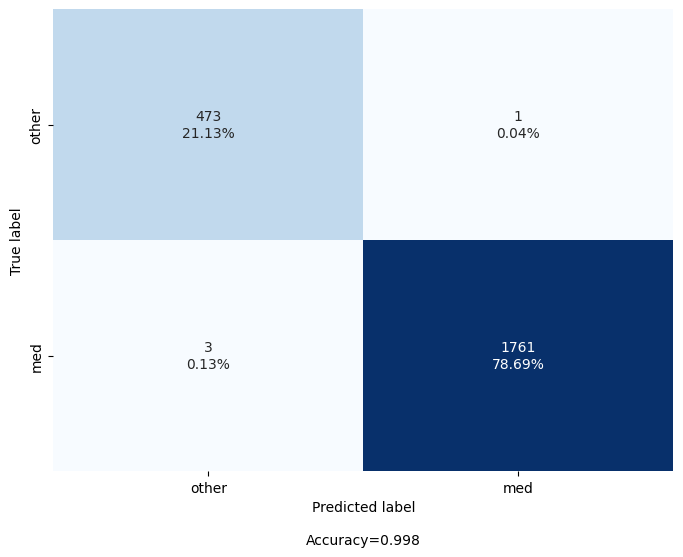

In [83]:
training_rows_DS, train_rows, test_rows = format_rows_for_train(labeled_df, 'input_row_stop', 'labels_med')
print_label_counts(training_rows_DS)

accuracy_metric = run_model_v9(train_rows, test_rows, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  True)

del base_model
gc.collect()
torch.cuda.empty_cache()

## Base Model Multi classification on all categories
This Model is a Multi classification of all categories with stop words included.

It achieved a 98.7% accuracy

In [15]:
max_length=512
out_put_dir = "./jobLevel_multi_bert_all_1"
tokeninzer_out_put_dir = out_put_dir+"_tokenizer"
id2label = {0:  "technology", 1: "medical", 2:"marketing and sales", 3:"law", 4: "service industry", 5:"retail", 6:"education", 7:"customer service", 8:"engineering and architecture", 9: "skilled trades", 10: "hr", 11: "finance"}
label2id = {"technology": 0, "medical": 1, "marketing and sales": 2, "law": 3, "service industry": 4, "retail": 5, "education": 6, "customer service": 7, "engineering and architecture": 8, "skilled trades": 9, "hr": 10, "finance": 11}
tokenizer_config = {'max_length': max_length,
                    'truncation': True,
                    'padding': True}

train_batch = 4
test_batch = 4
epochs = 5

tokenizer_funct = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).cuda()

special_tokens_dict = {'additional_special_tokens': ['[TITLE]', '[DESC]']}
tokenizer_funct.add_special_tokens(special_tokens_dict)
# Save the tokenizer and config
tokenizer_funct.save_pretrained(tokeninzer_out_put_dir)
os.makedirs(tokeninzer_out_put_dir, exist_ok=True)
with open(tokeninzer_out_put_dir+"/tokenizer_config.json", "w") as f:
    json.dump(tokenizer_config, f)
    
base_model.resize_token_embeddings(len(tokenizer_funct))
print_GPU()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total GPU memory: 8192 MB
GPU memory occupied: 2284 MB
GPU memory free: 5907 MB


Label counts for train set:
1: 1611 | 2: 1600 | 0: 1598 | 5: 1594 | 7: 1585 | 11: 1575 | 4: 954 | 9: 838 | 8: 763 | 3: 761 | 10: 754 | 6: 428 
Label counts for test set:
11: 425 | 7: 415 | 5: 406 | 0: 402 | 2: 400 | 1: 389 | 4: 225 | 8: 216 | 9: 189 | 10: 183 | 3: 162 | 6: 104 


Map:   0%|          | 0/14061 [00:00<?, ? examples/s]

Map:   0%|          | 0/3516 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 3516
  Batch size = 4


The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14,061
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 17,580
  Number of trainable parameters = 66,964,236


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.000900,0.220586,0.001100,0.968146
2,0.000500,0.105804,0.001100,0.984357
3,0.621300,0.110618,0.001100,0.986917
4,0.000100,0.086750,0.001100,0.988908
5,0.000100,0.089437,0.001100,0.989761


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 3516
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_all_1/checkpoint-3516
Configuration saved in ./jobLevel_multi_bert_all_1/checkpoint-3516/config.json
Model weights saved in ./jobLevel_multi_bert_all_1/checkpoint-3516/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 3516
  Batch size = 4
Saving model checkpoint to ./jobLevel_multi_bert_all_1/checkpoint-7032
Configuratio

Saving model checkpoint to ./jobLevel_multi_bert_all_1
Configuration saved in ./jobLevel_multi_bert_all_1/config.json
Model weights saved in ./jobLevel_multi_bert_all_1/model.safetensors
loading configuration file ./jobLevel_multi_bert_all_1/config.json
Model config DistilBertConfig {
  "_name_or_path": "./jobLevel_multi_bert_all_1",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "technology",
    "1": "medical",
    "2": "marketing and sales",
    "3": "law",
    "4": "service industry",
    "5": "retail",
    "6": "education",
    "7": "customer service",
    "8": "engineering and architecture",
    "9": "skilled trades",
    "10": "hr",
    "11": "finance"
  },
  "initializer_range": 0.02,
  "label2id": {
    "customer service": 7,
    "education": 6,
    "engineering and architecture": 8,
    "finance": 11,
    "hr": 10,
    "law": 

Eval Model before train
Accuracy: 6.26%, Loss: 2.49, Time: 27.1721
Eval Model After train
Accuracy: 98.89%, Loss: 0.09, Time: 25.6694


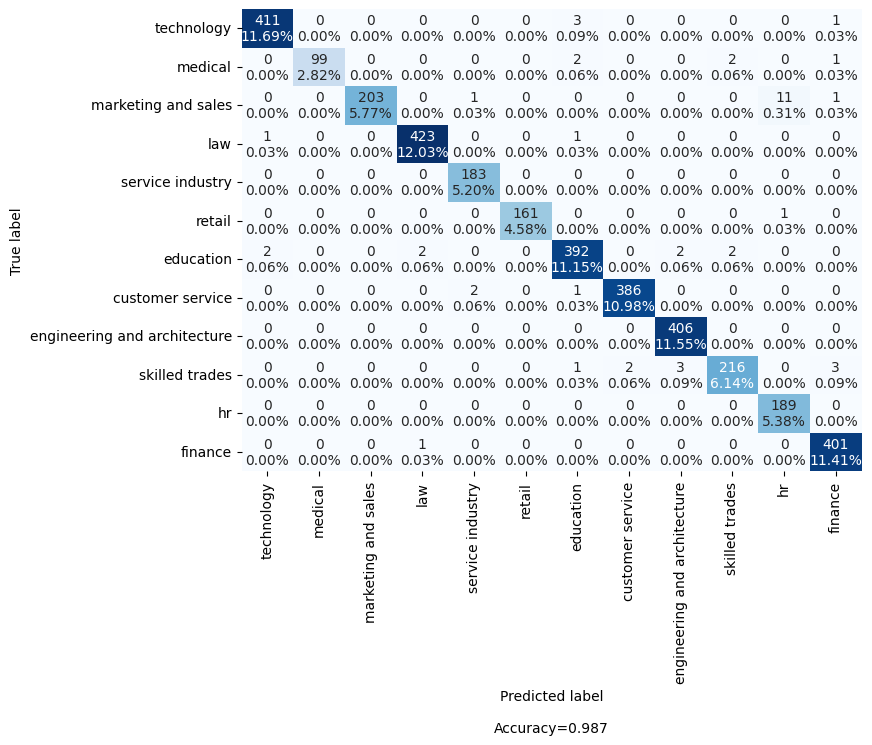

In [16]:
training_rows_DS, train_rows, test_rows = format_rows_for_train(balanced_df_1, 'input_row', 'labels_fixed')
print_label_counts(training_rows_DS)

accuracy_metric = run_model_v9(train_rows, test_rows, tokenizer_funct, tokenizer_config, epochs, train_batch, test_batch, base_model, out_put_dir, compute_metrics, id2label, label2id,  True)

del base_model
gc.collect()
torch.cuda.empty_cache()

# Test On unlabeled Data

In [19]:
# load Data and grab the unlabeled rows. 
df_93 = pd.read_csv('job_type_data/jobs_93k.csv')
df_93.drop(['Unnamed: 0','Unnamed: 7','Unnamed: 8','.'], axis=1, inplace=True)
unlabeled_df = df_93[df_93["labels"].isnull()]
unlabeled_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_285162/775344393.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_93 = pd.read_csv('job_type_data/jobs_93k.csv')


In [20]:
unlabeled_df

,company,title,description,title_processed,labels
0,regions::wd5::Regions_Careers,Guided Solutions Phone Banker Remote Position ...,Thank you for your interest in a career at Reg...,guided solutions phone banker remote position ...,NaN
1,rhombus-systems,Product Manager - API & Integrations,"Who We Are Founded in 2016, Rhombus is on a m...",product manager - api & integrations,NaN
2,EndeavorITSolution,hiring for android developer interns,This is an opportunity to join a motivated An...,hiring for android developer interns,NaN
3,daveandbusters::wd1::Dave_and_Busters_Careers,Game Support Technician,Job Description:Dave & Busters is different fr...,game support technician,NaN
4,cibc::wd3::campus,"Telephone Banking Servicing Agent, Remote - Bi...",Were building a relationship-oriented bank for...,"telephone banking servicing agent, remote - bi...",NaN
...,...,...,...,...,...
66638,60decibelsinc,"Research Coordinator, Kenya",60 Decibels is a tech-powered impact measureme...,"research coordinator, kenya",NaN
66639,fogo::wd5::Fogo,Market Table Attendant,"At Fogo de Cho, we strive to give our guests a...",market table attendant,NaN
66640,binance,Social Media Specialist (TikTok & Youtube),Binance is the leading global blockchain ecosy...,social media specialist tiktok & youtube,NaN
66641,roche::wd3::roche-ext,Data Scientist,"Roche fosters diversity, equity and inclusion,...",data scientist,NaN


In [21]:
unlabeled_df["title"] = unlabeled_df["title"].astype(str)
unlabeled_df["company"] = unlabeled_df["company"].astype(str)
unlabeled_df["description"] = unlabeled_df["description"].astype(str)
unlabeled_df["title_processed"] = unlabeled_df["title_processed"].astype(str)

/tmp/ipykernel_285162/3458410643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["title"] = unlabeled_df["title"].astype(str)
/tmp/ipykernel_285162/3458410643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["company"] = unlabeled_df["company"].astype(str)
/tmp/ipykernel_285162/3458410643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [22]:
# Apply pre-processing and build input rows. 
unlabeled_df['description_processed'] = unlabeled_df['description'].progress_apply(preprocess_text)
unlabeled_df['description_processed_stop'] = unlabeled_df['description_processed'].progress_apply(remove_stop)
unlabeled_df['title_processed_stop'] = unlabeled_df['title_processed'].progress_apply(remove_stop)
unlabeled_df['input_row'] = unlabeled_df.progress_apply(lambda x: concat_columns(x, 'title_processed', 'description_processed'), axis=1)

100%|██████████| 66643/66643 [00:46<00:00, 1447.89it/s]
/tmp/ipykernel_285162/1737009714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df['description_processed'] = unlabeled_df['description'].progress_apply(preprocess_text)
100%|██████████| 66643/66643 [02:22<00:00, 469.28it/s]
/tmp/ipykernel_285162/1737009714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df['description_processed_stop'] = unlabeled_df['description_processed'].progress_apply(remove_stop)
100%|██████████| 666

In [12]:
out_put_dir = "./jobLevel_multi_bert_all_1"
tokeninzer_out_put_dir = out_put_dir+"_tokenizer"

In [13]:
# Load tokenizer and tokenizer config
loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(tokeninzer_out_put_dir)
with open(tokeninzer_out_put_dir + "/tokenizer_config.json", "r") as f:
    tokenizer_config = json.load(f)

max_length = tokenizer_config.get('max_length', 256)
truncation = tokenizer_config.get('truncation', True)
padding = tokenizer_config.get('padding', 'max_length')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


In [41]:
# Load Model. 
loaded_model = DistilBertForSequenceClassification.from_pretrained(out_put_dir).cuda()
loaded_model.eval()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
unlabeled_df.drop(['labels'], axis=1, inplace=True)

/tmp/ipykernel_285162/3373412548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df.drop(['labels'], axis=1, inplace=True)


In [28]:
text = unlabeled_df.loc[0]['input_row']

In [36]:
# Test on Single example
inputs = loaded_tokenizer(
    text,
    max_length=max_length,
    truncation=truncation,
    padding=padding,
    return_tensors="pt"
).to('cuda')
with torch.no_grad(): 
    outputs = loaded_model(**inputs)

logits = outputs.logits.cpu()

predicted_class = torch.argmax(logits, dim=-1).item()
print(f"Predicted class: {predicted_class}")

Predicted class: 7


In [37]:
def predict_class(text):
    """
    Function to make prediction on text input
    """
    inputs = loaded_tokenizer(
        text,
        max_length=max_length,
        truncation=truncation,
        padding=padding,
        return_tensors="pt"
    ).to('cuda')
    
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    
    logits = outputs.logits.cpu()
    predicted_class = torch.argmax(logits, dim=-1).item()
    
    return predicted_class

In [38]:
# Sample 1000 rows. 
test_df = unlabeled_df.sample(10000, random_state=42)
test_df.shape

(10000, 8)

In [39]:
test_df.columns

Index(['company', 'title', 'description', 'title_processed',
       'description_processed', 'description_processed_stop',
       'title_processed_stop', 'input_row'],
      dtype='object')

In [40]:
# Make prediction on data frame.
test_df['labels'] = test_df['input_row'].progress_apply(predict_class)

100%|██████████| 10000/10000 [01:35<00:00, 104.56it/s]


In [41]:
test_df

,company,title,description,title_processed,description_processed,description_processed_stop,title_processed_stop,input_row,labels
44533,hightechhigh,K-5 Elementary Teacher for 2024-2025 School Year,Elementary Teacher Reports To: School Direc...,k-5 elementary teacher for 2024-2025 school year,elementary teacher reports to school director ...,elementary teacher reports school director fls...,k-5 elementary teacher 2024-2025 school year,[TITLE] k-5 elementary teacher for 2024-2025 s...,6
61014,lowes::wd5::LWS_External_CS,In Home Consultant,What You Will Do All Lowes associates deliver ...,in home consultant,what you will do all lowes associates deliver ...,lowes associates deliver quality customer serv...,home consultant,[TITLE] in home consultant [DESC] what you wil...,4
7677,carrier::wd5::jobs,Indirect Purchasing,Country: ThailandLocation: Carrier (Thailand) ...,indirect purchasing,country thailandlocation carrier thailand limi...,country thailandlocation carrier thailand limi...,indirect purchasing,[TITLE] indirect purchasing [DESC] country tha...,4
60161,csl::wd1::CSL_External,Quality Specialist,The OpportunityThis position provides immediat...,quality specialist,the opportunitythis position provides immediat...,opportunitythis position provides immediate su...,quality specialist,[TITLE] quality specialist [DESC] the opportun...,1
16171,myhrhome::wd1::OneMainCareers,Consumer Loan Sales Specialist,"At OneMain, Consumer Loan Sales Specialists em...",consumer loan sales specialist,"at onemain, consumer loan sales specialists em...","onemain , consumer loan sales specialists empo...",consumer loan sales specialist,[TITLE] consumer loan sales specialist [DESC] ...,11
...,...,...,...,...,...,...,...,...,...
66393,pacs::wd1::pacs,Dietitian,"Prepare/approve menus, diets and dietary depar...",dietitian,"prepare approve menus, diets and dietary depar...","prepare approve menus , diets dietary departme...",dietitian,[TITLE] dietitian [DESC] prepare approve menus...,4
29270,hospicecom::wd5::Compassus,RN Home Health,"Company:CompassusAt Ascension at Home, Togethe...",right now home health,"company compassusat ascension at home, togethe...","company compassusat ascension home , together ...",right home health,[TITLE] right now home health [DESC] company c...,4
147,pwc::wd3::Global_Experienced_Careers,Senior Associate _SAP ABAP_Enterprise Apps SAP...,Line of ServiceAdvisoryIndustry/SectorNot Appl...,senior associate _sap abap_enterprise apps sap...,line of serviceadvisoryindustry sectornot appl...,line serviceadvisoryindustry sectornot applica...,senior associate _sap abap_enterprise apps sap...,[TITLE] senior associate _sap abap_enterprise ...,4
12659,heequipment::wd5::careers,"Shop Technician - Victoria, TX","Job Title:Shop Technician - Victoria, TXJob Re...","shop technician - victoria, tx","job title shop technician - victoria, txjob re...","job title shop technician - victoria , txjob r...","shop technician - victoria , tx","[TITLE] shop technician - victoria, tx [DESC] ...",9


In [42]:
test_df['label_str'] = test_df['labels'].progress_apply(lambda x: id2label[x]) 

100%|██████████| 10000/10000 [00:00<00:00, 540712.13it/s]


In [43]:
# Save the dataframe to view in excel.
test_df.to_csv('job_type_data/model_labeled.csv', header=True)

# Data Explore

This was the intial data exploration done on the raw data set. 

In [52]:
e_df = pd.read_csv('MASTER_DF.csv', index_col=0)

In [9]:
null_counts = e_df.isnull().sum()
print(null_counts)

id                  0
title               0
description         0
company             0
raw_location        7
label           19014
labeledby       18995
dtype: int64


In [41]:
def calculate_total_token_count(text, tokenizer_funct):
    encoded_dict = tokenizer_funct.encode_plus(
        text,
        add_special_tokens=True, 
        max_length=512,  
        truncation=True,
        return_overflowing_tokens=True,  
    )
    total_token= 0
    for x in range(len(encoded_dict['input_ids'])):
        total_token += len(encoded_dict['input_ids'][x])
        if x !=0:
            total_token-=2
    
    return total_token


In [53]:
e_df['tk_count_description'] = e_df['description'].apply(lambda x: calculate_total_token_count(x, tokenizer_funct))
e_df['tk_count_title'] = e_df['title'].apply(lambda x: calculate_total_token_count(x.lower(), tokenizer_funct))
e_df['processed_description'] = e_df['description'].apply(lambda x: preprocess_text(x))
e_df['tk_count_pre_description'] = e_df['processed_description'].apply(lambda x: calculate_total_token_count(x, tokenizer_funct))

e_df['fmt_text'] = e_df[['title', 'processed_description']].apply(lambda x: f"title {x['title'].lower()} description {x['processed_description']}", axis=1)

e_df['tk_count_fmt_text'] = e_df['fmt_text'].apply(lambda x: calculate_total_token_count(x, tokenizer_funct))


In [63]:
def describe_df(df):

    mean_token_fmt = df['tk_count_fmt_text'].mean()    
    max_token_fmt = df['tk_count_fmt_text'].max()
    
    mean_token_title = df['tk_count_title'].mean()    
    max_token_title = df['tk_count_title'].max()
    
    mean_token_p_description = df['tk_count_pre_description'].mean()    
    max_token_p_description = df['tk_count_pre_description'].max()
    
    count_fmt_rows_above_max_length = (df['tk_count_fmt_text'] > 512).sum()
    count_title_rows_above_mean = (df['tk_count_title'] > int(mean_token_title)).sum()

    
    
    print(f"Full text: Mean: {mean_token_fmt}, Max: {max_token_fmt}")
    print(f"Title text: Mean: {mean_token_title}, Max: {max_token_title}")
    print(f"Processed Description text: Mean: {mean_token_p_description}, Max: {max_token_p_description}")
    
    print(f"Title above mean title size: {count_title_rows_above_mean}, or {(count_title_rows_above_mean/len(df))*100:.2f}%")
    print(f"Processed Description text above 512: {count_fmt_rows_above_max_length}, or {(count_fmt_rows_above_max_length/len(df))*100:.2f}%")
    
    

In [64]:
describe_df(e_df)

Full text: Mean: 586.9636084059457, Max: 2805
Title text: Mean: 7.881137878011276, Max: 72
Processed Description text: Mean: 579.0824705279344, Max: 2791
Title above mean title size: 8798, or 45.09%
Processed Description text above 512: 11119, or 56.99%


## Data sample 100k  
The below cells were used to take the raw 100 thousand row data set clean it before hand labeling. 

In [102]:
all_df_100 = pd.read_csv('job_type_data/ALL_DATA_100k.csv')

In [103]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [105]:
all_df_100['description'] = all_df_100['description'].astype(str)

In [106]:
# Add is_not_english col
DetectorFactory.seed = 0
def is_not_english(text):
    try:
        return detect(text) != 'en'
    except LangDetectException:
        return True 
tqdm.pandas(desc="Processing descriptions")
all_df_100['is_not_english'] = all_df_100['description'].swifter.apply(is_not_english)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [108]:
all_df_100['is_not_english'].value_counts()

is_not_english
False    93834
True      6166
Name: count, dtype: int64

In [107]:
all_df_100['title'] = all_df_100['title'].astype(str)

In [109]:
all_df_100= all_df_100[all_df_100['is_not_english']==False]

In [110]:
all_df_100.shape

(93834, 4)

In [111]:
all_df_100 = all_df_100.drop('is_not_english', axis=1)

In [112]:
all_df_100 = all_df_100.reset_index(drop=True)

In [113]:
all_df_100.shape

(93834, 3)

In [115]:
all_df_100['title_processed'] = all_df_100['title'].progress_apply(preprocess_text)

Pandas Apply:   0%|          | 0/93834 [00:00<?, ?it/s]

In [116]:
# save the dataframe to csv.
all_df_100.to_csv('job_type_data/jobs_93k.csv', header=True)